In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

import pymc as pm
import pytensor as pt
from pymc import PolyaGamma as PG

In [15]:
def _compute_mean_a(v, b, theta, w, y):
    S = torch.sum(torch.mul(theta, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()

def _compute_var_a(sigmasq, theta, w):
    S = torch.sum(torch.mul(w, torch.pow(theta, 2))) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_b(v, a, theta, w, y):
    S = torch.sum(y-0.5-a*torch.mul(theta, w))
    mean = v*S
    return mean.item()

def _compute_var_b(sigmasq, w):
    S = torch.sum(w) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_t(v, a, b, w, y):    
    S = torch.sum(torch.mul(a, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()    

def _compute_var_t(sigmasq, w, a):
    S = torch.sum(torch.mul(w, torch.pow(a, 2))) + 1/sigmasq
    #print(S)
    var = 1/S

    #print(w)        # FIXME: issue is that w has negative values -> sum, S, becomes negative -> var is negative
    #print(a)
    return var.item()


def polyagamma(init_a, init_b, init_t, init_w, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):

    assert init_a.shape == init_b.shape
    assert init_t.shape[0] == y.shape[0]
    assert y.shape == init_w.shape
    
    I = len(init_a)
    P = len(init_t)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    W = torch.empty(size=(niter, P, I))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_t
    W[0] = init_w

    print(f"Starting Gibbs sampler for Polya-Gamma... \n--------------------------------------------\n")
    for s in trange(1, niter):

        # calculate scale values for PG draw
        Z = torch.abs(torch.mul(A[s-1, None], torch.t(THETA[s-1, None])) + B[s-1])
        assert Z.shape == (P, I)
        
        # sample Ws
        W[s] = torch.from_numpy(pm.draw(PG.dist(h=1, z=Z)))
        #print("sampled W: ", W[s]) 

        # sample As
        for i in range(I):
            var_a = _compute_var_a(sigmasq_a, THETA[s-1], W[s][:,i])
            mean_a = _compute_mean_a(var_a, B[s-1][i], THETA[s-1], W[s][:,i], y[:,i])
            A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()
            #try:
            #    A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()
            #except ValueError:
            #    A[s][i] = torch.distributions.Normal(mean_a, var_a+0.001).sample()

        # sample Bs
        for i in range(I):
            var_b = _compute_var_b(sigmasq_b, W[s][:,i])
            mean_b = _compute_mean_b(var_b, A[s][i], THETA[s-1], W[s][:,i], y[:,i])
            B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()
            #try: 
            #    B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()
            #except ValueError:
            #    B[s][i] = torch.distributions.Normal(mean_b, var_b+0.001).sample()

        # sample THETAs
        for p in range(P):
            var_t = _compute_var_t(sigmasq_t, W[s][p], A[s])
            mean_t = _compute_mean_t(var_t, A[s], B[s], W[s][p,:], y[p,:])
            THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()
            #try:
            #    THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()
            #except ValueError:
            #    var_t = torch.tensor([var_t + 0.0001])  
            #    THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()

    return A, B, THETA, W

In [20]:
# TEST

N = 10000   # iterations
I = 10     # exam items
P = 100    # pupils
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)
init_W = torch.zeros(P, I)

true_a, true_b = torch.empty(size=(I,)), torch.empty(size=(I,))  # items' difficulty and discriminatory power
true_theta = torch.empty(size=(P,))  # students' skills
true_W = torch.empty(size=(P,I))

# populate a, b:
for i in range(I):
    U1 = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U1.sample()
    
    U2 = torch.distributions.Uniform(torch.tensor([-1.0]), torch.tensor([0.0]))
    true_b[i] = U2.sample()

# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# populate W:
scales = torch.mul(torch.t(true_a[:, None]), true_theta[:, None]) + true_b
true_W = torch.from_numpy(pm.draw(PG.dist(h=1, z=scales)))
        
# exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] + true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] + true_b[i])) # trying +b
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[1., 1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 0., 1., 0., 0., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1.],
        [0., 1., 1., 1., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],


In [21]:
#N=1000
samples = polyagamma(init_a, init_b, init_t, init_W, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler for Polya-Gamma... 
--------------------------------------------



100%|██████████| 9999/9999 [04:08<00:00, 40.21it/s]


In [22]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

print("W:")
print(torch.mean(samples[3], 0))  # mean over the columns
print(true_W)

A:
tensor([-0.0827,  0.0306, -0.4559,  0.2306,  0.5916,  0.3747,  2.0546, -1.0429,
         3.1351,  1.0121])
tensor([0.3244, 0.1811, 0.6226, 0.6551, 0.1079, 0.3077, 0.6567, 0.3313, 0.1477,
        0.1596])
B:
tensor([-0.3179, -0.6449,  0.3772,  0.0886, -0.6398, -0.7693,  0.7189, -0.2402,
        -1.0029, -0.5711])
tensor([-0.5154, -0.8626, -0.1276, -0.2743, -0.7156, -0.9349, -0.2249, -0.6952,
        -0.5401, -0.4386])
THETA:
tensor([-0.7245, -0.6570,  0.4797,  0.0963, -0.8775, -0.3943, -0.8412,  0.1514,
        -0.4745, -0.8575, -0.4585,  1.0765,  0.0864, -0.0297,  1.4809, -1.1907,
         0.5641, -0.5073,  0.3397, -0.6151, -0.1600, -0.7788, -1.2874, -0.0521,
        -0.5411, -0.0982, -0.8807,  0.5993,  0.2610, -0.1448, -1.1716, -0.7956,
        -0.4933,  1.0056,  0.0514, -0.2091, -0.8465,  0.6260, -0.7579, -1.3176,
         0.7777, -0.2230,  0.2771, -0.7364, -0.4394,  0.5600, -0.1151, -0.7049,
         0.7430,  0.6355, -1.2863, -0.6568, -1.0001,  0.8028,  0.2732, -0.3521,
        -

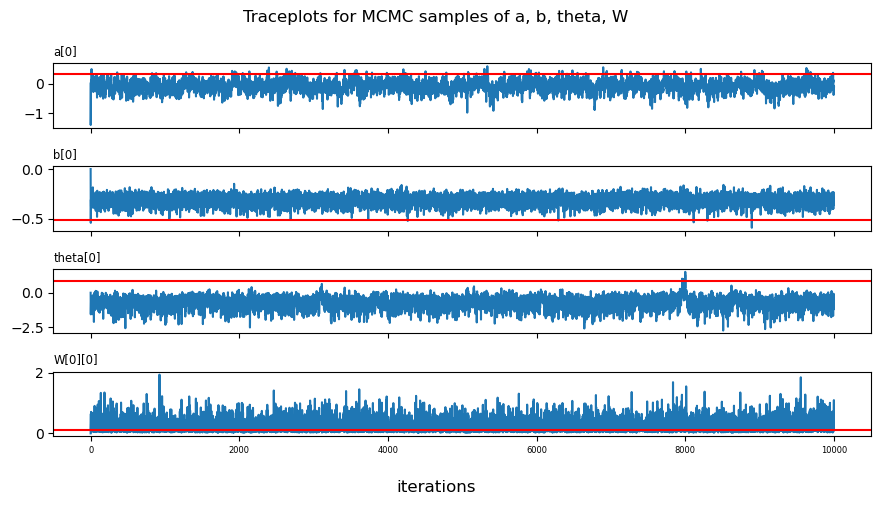

In [23]:
# Traceplots of samples
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta, W')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

ax4.plot(t, samples[3][:,0,0])
ax4.axhline(true_W[0][0], color="red")
ax4.set_title("W[0][0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

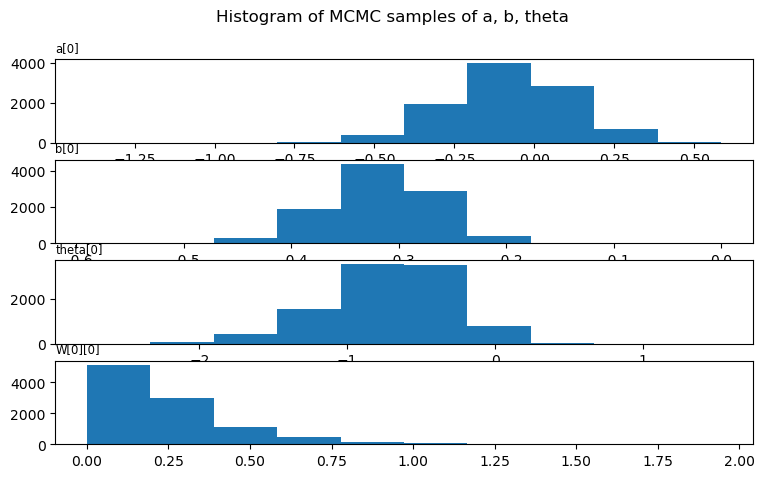

In [24]:
# Histogram of samples
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')
ax4.hist(samples[3][:,0,0])
ax4.set_title("W[0][0]", fontsize='small', loc='left')

plt.show()